# Statistics Analysis and Filtering Tool

This notebook reads the statistics CSV generated by `stats_data.py` and provides:
1. Overall statistics tables
2. Per-year statistics tables
3. Functions to filter movies by plot/summary length
4. Functions to find movies with all features present


In [1]:
"""
Statistics Analysis and Filtering

This notebook provides tools for analyzing movie statistics and filtering data.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from pathlib import Path
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# Add parent directories to path
try:
    BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
    if BASE_DIR not in sys.path:
        sys.path.insert(0, BASE_DIR)
except NameError:
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
    if BASE_DIR not in sys.path:
        sys.path.insert(0, BASE_DIR)

DATA_DIR = os.path.join(BASE_DIR, 'data')
STATS_FILE = os.path.join(DATA_DIR, 'data_statistics.csv')

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Stats file: {STATS_FILE}")
print(f"Stats file exists: {os.path.exists(STATS_FILE)}")


Base directory: /home/nab/GroupDataLiteracy
Data directory: /home/nab/GroupDataLiteracy/data
Stats file: /home/nab/GroupDataLiteracy/data/data_statistics.csv
Stats file exists: True


In [2]:
# Import functions from stats_data.py to load movie data
from stats_data import load_all_data, find_year_files

# Load statistics CSV
stats_df = pd.read_csv(STATS_FILE)
print(f"Loaded statistics CSV with {len(stats_df)} rows")
print(f"\nStatistics CSV columns: {list(stats_df.columns)}")
print(f"\nScopes available: {stats_df['scope'].unique()}")
print(f"\nYears available: {sorted(stats_df[stats_df['scope'] == 'Per-Year']['year'].unique())}")


Loaded statistics CSV with 1596 rows

Statistics CSV columns: ['scope', 'year', 'field', 'total_movies', 'present', 'missing', 'percentage', 'avg_length', 'min_length', 'max_length']

Scopes available: ['Overall' 'Per-Year']

Years available: ['1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']


In [3]:
# Separate overall and per-year statistics
overall_stats = stats_df[stats_df['scope'] == 'Overall'].copy()
per_year_stats = stats_df[stats_df['scope'] == 'Per-Year'].copy()

print(f"Overall statistics: {len(overall_stats)} rows")
print(f"Per-year statistics: {len(per_year_stats)} rows")

# Display overall statistics table
print("\n" + "="*100)
print("OVERALL STATISTICS")
print("="*100)

# Create a formatted table for overall stats
overall_display = overall_stats[['field', 'present', 'missing', 'percentage', 'avg_length', 'min_length', 'max_length']].copy()
overall_display['percentage'] = overall_display['percentage'].apply(lambda x: f"{x:.2f}%")
overall_display['avg_length'] = overall_display['avg_length'].apply(lambda x: f"{x:.2f}" if pd.notna(x) else "N/A")
overall_display['min_length'] = overall_display['min_length'].apply(lambda x: f"{int(x)}" if pd.notna(x) else "N/A")
overall_display['max_length'] = overall_display['max_length'].apply(lambda x: f"{int(x)}" if pd.notna(x) else "N/A")

# Rename columns for better display
overall_display.columns = ['Field', 'Present', 'Missing', 'Percentage', 'Avg Length', 'Min Length', 'Max Length']

display(overall_display)


Overall statistics: 21 rows
Per-year statistics: 1575 rows

OVERALL STATISTICS


,Field,Present,Missing,Percentage,Avg Length,Min Length,Max Length
0,movie_id,214682,0,100.00%,8.54,4,10
1,title,214682,0,100.00%,16.59,1,184
2,summary,0,214682,0.00%,N/A,N/A,N/A
3,release_date,214682,0,100.00%,20.01,20,74
4,genre,176286,38396,82.11%,21.71,4,414
5,director,190633,24049,88.80%,14.91,1,1163
6,actors,145397,69285,67.73%,117.38,1,4548
7,duration,131062,83620,61.05%,2.35,1,74
8,imdb_id,202057,12625,94.12%,9.09,7,14
9,country,205006,9676,95.49%,8.85,4,74


In [7]:
# Group yearly statistics into decades and average within each decade

# We'll group 'actors' and 'director' together and report their average as one column.
# We'll ignore 'imdb_id' and 'tmdb_id' completely.

key_fields = ['director', 'actors', 'genre', 'plot', 'duration', 
              'popularity', 'vote_count']

# Ensure year is integer, in case it's read as string
per_year_stats = per_year_stats.copy()  # Avoid SettingWithCopyWarning
per_year_stats['year'] = pd.to_numeric(per_year_stats['year'], errors='coerce')
per_year_stats = per_year_stats.dropna(subset=['year'])
per_year_stats['year'] = per_year_stats['year'].astype(int)

# Only use the relevant fields (excluding imdb_id and tmdb_id)
filtered_stats = per_year_stats[per_year_stats['field'].isin(key_fields)]

# Pivot table by year
per_year_pivot = filtered_stats.pivot_table(
    index='year',
    columns='field',
    values='percentage',
    fill_value=0
)
per_year_pivot = per_year_pivot.sort_index()

# Compute combined 'Actors & Director' column by averaging those two
per_year_pivot['Actors+Director'] = per_year_pivot[['actors', 'director']].mean(axis=1)

# Remove 'actors' and 'director'; keep 'Actors+Director'
cols_order = [col for col in per_year_pivot.columns if col not in ['actors', 'director']]
# Move 'Actors+Director' to the first column (for visibility)
cols_order = ['Actors+Director'] + [c for c in cols_order if c != 'Actors+Director']
per_year_pivot = per_year_pivot[cols_order]

# Create a decade column from the year index (now guaranteed numeric)
decade_bins = (per_year_pivot.index // 10) * 10
per_year_pivot['decade'] = decade_bins

# Group by decade and compute the mean for each key field in the decade/combined field
per_decade_pivot = per_year_pivot.groupby('decade').mean(numeric_only=True)
per_decade_pivot.index = [f"{int(dec)}s" for dec in per_decade_pivot.index]

# Add a final 'Average' row for the grand mean
per_decade_pivot.loc['Average'] = per_decade_pivot.mean(axis=0)

print("\n" + "="*100)
print("PER-DECADE STATISTICS (Average Percentage Completeness by Decade)")
print("="*100)

display(per_decade_pivot)

# Save the per-decade pivot as a CSV in the data folder
per_decade_pivot.to_csv(os.path.join(DATA_DIR, "per_decade_stats.csv"))



PER-DECADE STATISTICS (Average Percentage Completeness by Decade)


field,Actors+Director,duration,genre,plot,popularity,vote_count
1950s,86.559500,63.6730,83.027000,86.659000,90.18900,90.18900
1960s,83.818500,61.0140,77.309000,75.414000,85.26300,85.26300
1970s,86.550000,62.4720,79.574000,74.198000,86.57900,86.57900
1980s,84.684500,59.4100,79.795000,75.793000,85.41400,85.41400
1990s,82.220000,58.3290,81.996000,77.932000,84.48900,84.48900
2000s,77.339000,60.5130,84.192000,76.628000,83.72700,83.72700
2010s,70.249000,60.5530,84.940000,71.759000,85.60500,85.60500
2020s,70.661000,64.8480,77.592000,73.146000,89.63200,89.63200
Average,80.260187,61.3515,81.053125,76.441125,86.36225,86.36225


In [ ]:
# Also show total movies per year
movies_per_year = per_year_stats.groupby('year')['total_movies'].first().sort_index()

print("\n" + "="*80)
print("MOVIES PER YEAR")
print("="*80)

year_counts_df = pd.DataFrame({
    'Year': movies_per_year.index,
    'Total Movies': movies_per_year.values
})

display(year_counts_df)

print(f"\nTotal movies across all years: {movies_per_year.sum():,}")
print(f"Number of years: {len(movies_per_year)}")
print(f"Average movies per year: {movies_per_year.mean():.0f}")
print(f"Year with most movies: {movies_per_year.idxmax()} ({movies_per_year.max():,} movies)")
print(f"Year with least movies: {movies_per_year.idxmin()} ({movies_per_year.min():,} movies)")



MOVIES PER YEAR


,Year,Total Movies
0,1950,1523
1,1951,1331
2,1952,1357
3,1953,1475
4,1954,1329
...,...,...
70,2020,3387
71,2021,3484
72,2022,3765
73,2023,3355



Total movies across all years: 214,682
Number of years: 75
Average movies per year: 2862
Year with most movies: 2016 (7,591 movies)
Year with least movies: 1956 (1,320 movies)


## Load Actual Movie Data for Filtering

Now we'll load the actual movie data so we can filter by plot length and feature completeness.


In [ ]:
# Load all movie data
print("Loading all movie data files...")
combined_df, year_dataframes = load_all_data(DATA_DIR)

print(f"\nLoaded {len(combined_df):,} total movies")
print(f"Years available: {sorted(year_dataframes.keys())}")
print(f"\nColumns in dataset: {list(combined_df.columns)}")

# Check which text column is available
has_plot = 'plot' in combined_df.columns
has_summary = 'summary' in combined_df.columns

if has_plot:
    text_column = 'plot'
    print(f"\nUsing 'plot' column for text analysis ({combined_df['plot'].notna().sum():,} movies have plots)")
elif has_summary:
    text_column = 'summary'
    print(f"\nUsing 'summary' column for text analysis ({combined_df['summary'].notna().sum():,} movies have summaries)")
else:
    text_column = None
    print("\nWarning: No 'plot' or 'summary' column found!")


2025-11-02 19:39:20,292 - stats_data - INFO - Found 75 year files
2025-11-02 19:39:20,318 - stats_data - INFO - Year 1950: Loaded 1523 movies from wikidata_movies_1950.csv
2025-11-02 19:39:20,341 - stats_data - INFO - Year 1951: Loaded 1331 movies from wikidata_movies_1951.csv
2025-11-02 19:39:20,362 - stats_data - INFO - Year 1952: Loaded 1357 movies from wikidata_movies_1952.csv
2025-11-02 19:39:20,386 - stats_data - INFO - Year 1953: Loaded 1475 movies from wikidata_movies_1953.csv
2025-11-02 19:39:20,407 - stats_data - INFO - Year 1954: Loaded 1329 movies from wikidata_movies_1954.csv


Loading all movie data files...


2025-11-02 19:39:20,430 - stats_data - INFO - Year 1955: Loaded 1352 movies from wikidata_movies_1955.csv
2025-11-02 19:39:20,453 - stats_data - INFO - Year 1956: Loaded 1320 movies from wikidata_movies_1956.csv
2025-11-02 19:39:20,477 - stats_data - INFO - Year 1957: Loaded 1439 movies from wikidata_movies_1957.csv
2025-11-02 19:39:20,501 - stats_data - INFO - Year 1958: Loaded 1422 movies from wikidata_movies_1958.csv
2025-11-02 19:39:20,525 - stats_data - INFO - Year 1959: Loaded 1410 movies from wikidata_movies_1959.csv
2025-11-02 19:39:20,550 - stats_data - INFO - Year 1960: Loaded 1437 movies from wikidata_movies_1960.csv
2025-11-02 19:39:20,573 - stats_data - INFO - Year 1961: Loaded 1391 movies from wikidata_movies_1961.csv
2025-11-02 19:39:20,596 - stats_data - INFO - Year 1962: Loaded 1495 movies from wikidata_movies_1962.csv
2025-11-02 19:39:20,618 - stats_data - INFO - Year 1963: Loaded 1400 movies from wikidata_movies_1963.csv
2025-11-02 19:39:20,645 - stats_data - INFO - 


Loaded 214,682 total movies
Years available: [1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

Columns in dataset: ['movie_id', 'title', 'summary', 'release_date', 'genre', 'director', 'actors', 'duration', 'imdb_id', 'country', 'sitelinks', 'wikipedia_link', 'budget', 'box_office', 'awards', 'set_in_period', 'year', 'popularity', 'vote_average', 'vote_count', 'tmdb_id', 'plot']

Using 'plot' column for text analysis (161,553 movies have plots)


In [ ]:
def is_field_present(df: pd.DataFrame, field: str) -> pd.Series:
    """
    Check if a field is present (non-null and non-empty) for each row.
    """
    if field not in df.columns:
        return pd.Series([False] * len(df), index=df.index)
    
    if df[field].dtype == 'object':
        # For string fields, check for non-null and non-empty strings
        return df[field].notna() & (df[field].astype(str).str.strip() != '') & (df[field].astype(str) != 'nan')
    else:
        return df[field].notna()


def filter_by_plot_length(df: pd.DataFrame, min_length: int = None, max_length: int = None, 
                          text_column: str = None) -> pd.DataFrame:
    """
    Filter movies by plot/summary length.
    
    Args:
        df: DataFrame with movie data
        min_length: Minimum plot length in characters (inclusive)
        max_length: Maximum plot length in characters (inclusive)
        text_column: Column name for text ('plot' or 'summary'), auto-detects if None
    
    Returns:
        Filtered DataFrame
    """
    if text_column is None:
        if 'plot' in df.columns:
            text_column = 'plot'
        elif 'summary' in df.columns:
            text_column = 'summary'
        else:
            raise ValueError("No 'plot' or 'summary' column found in DataFrame")
    
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame")
    
    # Calculate text lengths
    text_lengths = df[text_column].astype(str).str.len()
    
    # Apply filters
    mask = pd.Series([True] * len(df), index=df.index)
    
    if min_length is not None:
        mask = mask & (text_lengths >= min_length)
    
    if max_length is not None:
        mask = mask & (text_lengths <= max_length)
    
    # Also filter out null/empty values
    has_text = is_field_present(df, text_column)
    mask = mask & has_text
    
    filtered_df = df[mask].copy()
    filtered_df['plot_length'] = text_lengths[mask]
    
    return filtered_df


def count_by_plot_length(df: pd.DataFrame, min_length: int, max_length: int, 
                        text_column: str = None) -> int:
    """
    Count movies with plot/summary length between min_length and max_length.
    """
    filtered = filter_by_plot_length(df, min_length, max_length, text_column)
    return len(filtered)


def filter_all_features_present(df: pd.DataFrame, required_fields: List[str] = None) -> pd.DataFrame:
    """
    Filter movies where all specified features are present.
    
    Args:
        df: DataFrame with movie data
        required_fields: List of field names that must be present. 
                        If None, uses all non-year fields.
    
    Returns:
        Filtered DataFrame with only movies having all required fields
    """
    if required_fields is None:
        # Use all fields except 'year' and internal columns
        required_fields = [col for col in df.columns 
                          if col not in ['year', 'plot_length']]
    
    # Check which fields are available
    available_fields = [f for f in required_fields if f in df.columns]
    missing_fields = [f for f in required_fields if f not in df.columns]
    
    if missing_fields:
        print(f"Warning: Fields not found in DataFrame: {missing_fields}")
    
    if not available_fields:
        print("Warning: No available fields to check!")
        return df.iloc[0:0].copy()  # Return empty DataFrame
    
    print(f"Checking {len(available_fields)} fields: {available_fields}")
    
    # Create mask for all fields present
    mask = pd.Series([True] * len(df), index=df.index)
    
    for field in available_fields:
        field_mask = is_field_present(df, field)
        mask = mask & field_mask
    
    filtered_df = df[mask].copy()
    
    # Print summary
    print(f"\nOriginal movies: {len(df):,}")
    print(f"Movies with all required fields: {len(filtered_df):,}")
    print(f"Percentage: {len(filtered_df)/len(df)*100:.2f}%")
    
    return filtered_df


def get_plot_length_stats(df: pd.DataFrame, text_column: str = None) -> Dict:
    """
    Get statistics about plot/summary lengths.
    """
    if text_column is None:
        if 'plot' in df.columns:
            text_column = 'plot'
        elif 'summary' in df.columns:
            text_column = 'summary'
        else:
            return {}
    
    if text_column not in df.columns:
        return {}
    
    # Calculate lengths only for non-empty values
    has_text = is_field_present(df, text_column)
    text_lengths = df[has_text][text_column].astype(str).str.len()
    
    if len(text_lengths) == 0:
        return {}
    
    return {
        'count': len(text_lengths),
        'mean': text_lengths.mean(),
        'median': text_lengths.median(),
        'std': text_lengths.std(),
        'min': text_lengths.min(),
        'max': text_lengths.max(),
        'q25': text_lengths.quantile(0.25),
        'q75': text_lengths.quantile(0.75),
        'q90': text_lengths.quantile(0.90),
        'q95': text_lengths.quantile(0.95)
    }

print("Helper functions defined:")
print("  - filter_by_plot_length(): Filter movies by plot/summary length")
print("  - count_by_plot_length(): Count movies in a length range")
print("  - filter_all_features_present(): Filter movies with all features present")
print("  - get_plot_length_stats(): Get statistics about plot lengths")


Helper functions defined:
  - filter_by_plot_length(): Filter movies by plot/summary length
  - count_by_plot_length(): Count movies in a length range
  - filter_all_features_present(): Filter movies with all features present
  - get_plot_length_stats(): Get statistics about plot lengths


## Plot Length Statistics

Let's see the distribution of plot/summary lengths to help you decide on filtering ranges.



PLOT LENGTH STATISTICS


,Value
count,161553.00
mean,1368.96
median,684.00
std,1488.42
min,9.00
max,22552.00
q25,289.00
q75,2142.00
q90,3745.00
q95,4223.00



Key insights:
  - 161,553 movies have plots
  - Mean length: 1369 characters
  - Median length: 684 characters
  - 25th percentile: 289 characters
  - 75th percentile: 2142 characters
  - 95th percentile: 4223 characters


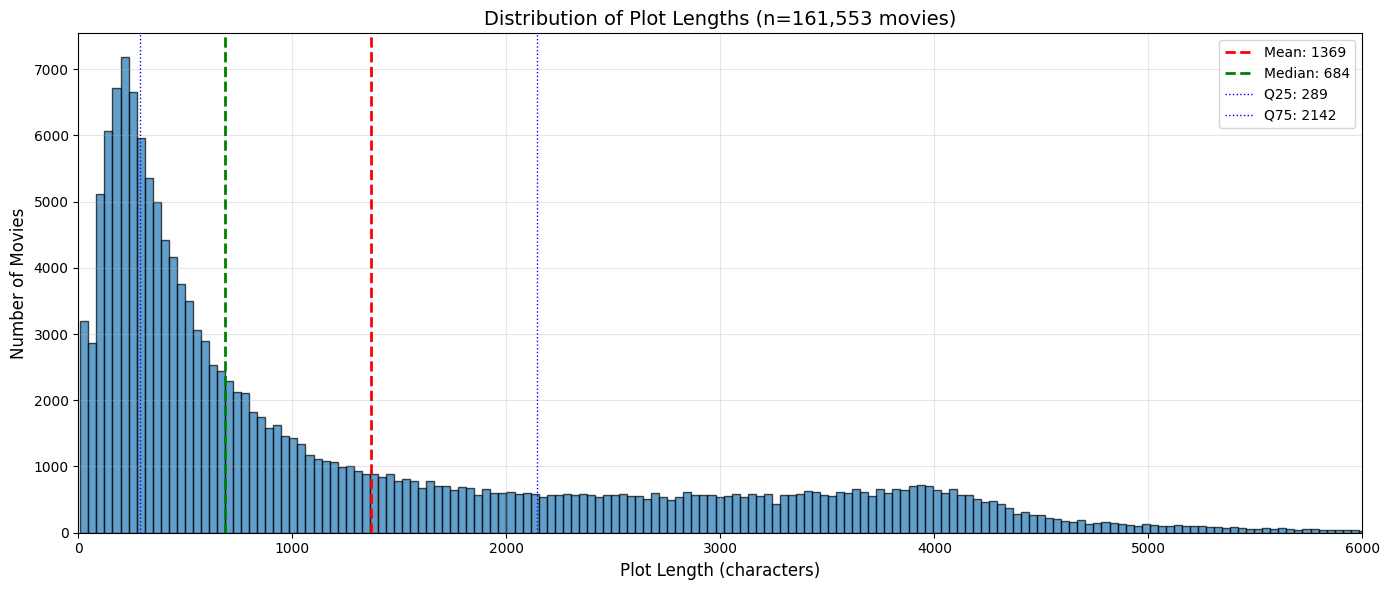

In [ ]:
# Get plot length statistics
if text_column:
    length_stats = get_plot_length_stats(combined_df, text_column)
    
    if length_stats:
        print(f"\n{text_column.upper()} LENGTH STATISTICS")
        print("="*80)
        
        stats_df = pd.DataFrame([length_stats]).T
        stats_df.columns = ['Value']
        stats_df['Value'] = stats_df['Value'].apply(lambda x: f"{x:.2f}" if isinstance(x, float) else f"{int(x):,}")
        
        display(stats_df)
        
        print(f"\nKey insights:")
        print(f"  - {length_stats['count']:,} movies have {text_column}s")
        print(f"  - Mean length: {length_stats['mean']:.0f} characters")
        print(f"  - Median length: {length_stats['median']:.0f} characters")
        print(f"  - 25th percentile: {length_stats['q25']:.0f} characters")
        print(f"  - 75th percentile: {length_stats['q75']:.0f} characters")
        print(f"  - 95th percentile: {length_stats['q95']:.0f} characters")
        
        # Create a histogram
        has_text = is_field_present(combined_df, text_column)
        text_lengths = combined_df[has_text][text_column].astype(str).str.len()
        
        plt.figure(figsize=(14, 6))
        plt.hist(text_lengths, bins=600, edgecolor='black', alpha=0.7)
        plt.xlabel(f'{text_column.capitalize()} Length (characters)', fontsize=12)
        plt.ylabel('Number of Movies', fontsize=12)
        plt.title(f'Distribution of {text_column.capitalize()} Lengths (n={length_stats["count"]:,} movies)', fontsize=14)
        plt.grid(True, alpha=0.3)
        plt.xlim(0, 6000)  # Limit x-axis to a maximum of 6000
        
        # Add vertical lines for key statistics
        plt.axvline(length_stats['mean'], color='red', linestyle='--', linewidth=2, label=f'Mean: {length_stats["mean"]:.0f}')
        plt.axvline(length_stats['median'], color='green', linestyle='--', linewidth=2, label=f'Median: {length_stats["median"]:.0f}')
        plt.axvline(length_stats['q25'], color='blue', linestyle=':', linewidth=1, label=f'Q25: {length_stats["q25"]:.0f}')
        plt.axvline(length_stats['q75'], color='blue', linestyle=':', linewidth=1, label=f'Q75: {length_stats["q75"]:.0f}')
        
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("No text column available for analysis")
else:
    print("No plot or summary column found in the data")


## Example Usage: Filtering Movies

Here are some example queries you can run. Modify the parameters as needed.


In [ ]:
# Example 1: Count movies with plot length between 500 and 2000 characters
if text_column:
    min_len = 500
    max_len = 2000
    count = count_by_plot_length(combined_df, min_len, max_len, text_column)
    print(f"Movies with {text_column} length between {min_len} and {max_len} characters: {count:,}")
    print(f"Percentage of total: {count/len(combined_df)*100:.2f}%")
    
    # Show some examples
    filtered = filter_by_plot_length(combined_df, min_len, max_len, text_column)
    print(f"\nSample movies in this range (first 5):")
    sample = filtered[['title', 'year', 'plot_length']].head()
    display(sample)


Movies with plot length between 500 and 2000 characters: 52,245
Percentage of total: 24.34%

Sample movies in this range (first 5):


,title,year,plot_length
22,King Solomon's Mines,1950,1953
34,Jour de Fête,1950,811
36,Joan of Arc,1950,879
37,Stromboli,1950,644
39,A Night in Casablanca,1950,1781


In [ ]:
# Example 2: Count movies with plot length >= 1000 characters (medium to long plots)
if text_column:
    min_len = 1000
    count = count_by_plot_length(combined_df, min_len, None, text_column)
    print(f"Movies with {text_column} length >= {min_len} characters: {count:,}")
    print(f"Percentage of total: {count/len(combined_df)*100:.2f}%")
    
    # Breakdown by year
    filtered = filter_by_plot_length(combined_df, min_len, None, text_column)
    year_breakdown = filtered.groupby('year').size().sort_index()
    print(f"\nBreakdown by year (first 10 years):")
    year_df = pd.DataFrame({
        'Year': year_breakdown.index[:10],
        'Count': year_breakdown.values[:10]
    })
    display(year_df)


Movies with plot length >= 1000 characters: 65,413
Percentage of total: 30.47%

Breakdown by year (first 10 years):


,Year,Count
0,1950,448
1,1951,383
2,1952,367
3,1953,412
4,1954,373
5,1955,409
6,1956,421
7,1957,445
8,1958,416
9,1959,422


In [ ]:
# Example 3: Find movies with all key features present
key_features = ['title', 'director', 'actors', 'genre', 'plot', 'duration', 
                'imdb_id', 'popularity', 'vote_average']

complete_movies = filter_all_features_present(combined_df, key_features)

print(f"\nSample of complete movies (first 5):")
sample_complete = complete_movies[['title', 'year', 'director', 'genre']].head()
display(sample_complete)


Checking 9 fields: ['title', 'director', 'actors', 'genre', 'plot', 'duration', 'imdb_id', 'popularity', 'vote_average']

Original movies: 214,682
Movies with all required fields: 76,446
Percentage: 35.61%

Sample of complete movies (first 5):


,title,year,director,genre
1,All About Eve,1950,Joseph L. Mankiewicz,"drama film, comedy film, film based on literature"
2,Rashomon,1950,Akira Kurosawa,"drama film, samurai cinema, crime film, mediev..."
3,The Third Man,1950,Carol Reed,"drama film, film noir, adventure film, mystery..."
4,Sunset Boulevard,1950,Billy Wilder,"drama film, film noir, flashback film"
5,All the King's Men,1950,Robert Rossen,"drama film, film noir, film based on a novel"


In [ ]:
# Example 4: Combine filters - Movies with all features AND plot length >= 1000
if text_column:
    # First filter by features
    key_features = ['title', 'director', 'actors', 'genre', 'plot']
    complete_movies = filter_all_features_present(combined_df, key_features)
    
    # Then filter by plot length
    min_plot_len = 1000
    filtered_combined = filter_by_plot_length(complete_movies, min_plot_len, None, text_column)
    
    print(f"\nMovies with all key features AND {text_column} length >= {min_plot_len}:")
    print(f"Count: {len(filtered_combined):,}")
    print(f"Percentage of total: {len(filtered_combined)/len(combined_df)*100:.2f}%")
    
    # Show breakdown by year
    year_breakdown = filtered_combined.groupby('year').size().sort_index()
    print(f"\nBreakdown by year:")
    year_df = pd.DataFrame({
        'Year': year_breakdown.index,
        'Count': year_breakdown.values
    })
    display(year_df)


Checking 5 fields: ['title', 'director', 'actors', 'genre', 'plot']

Original movies: 214,682
Movies with all required fields: 100,404
Percentage: 46.77%

Movies with all key features AND plot length >= 1000:
Count: 47,799
Percentage of total: 22.27%

Breakdown by year:


,Year,Count
0,1950,370
1,1951,297
2,1952,296
3,1953,328
4,1954,298
...,...,...
70,2020,623
71,2021,511
72,2022,652
73,2023,620


## Interactive Analysis Section

Use the cells below to perform custom analyses. You can modify the parameters to explore different filtering criteria.


In [ ]:
# CUSTOM FILTER 2: Filter by feature completeness
# Modify this list to specify which fields must be present
REQUIRED_FIELDS = ['title', 'director', 'actors', 'genre', 'plot', 'duration', 'imdb_id']

complete_movies = filter_all_features_present(combined_df, REQUIRED_FIELDS)

print(f"\nFields required: {REQUIRED_FIELDS}")
print(f"Movies with all required fields: {len(complete_movies):,}")

# Show completeness breakdown by year
if len(complete_movies) > 0:
    year_breakdown = complete_movies.groupby('year').size().sort_index()
    total_by_year = combined_df.groupby('year').size()
    
    completeness_df = pd.DataFrame({
        'Year': year_breakdown.index,
        'Complete': year_breakdown.values,
        'Total': [total_by_year.get(y, 0) for y in year_breakdown.index],
    })
    completeness_df['Percentage'] = (completeness_df['Complete'] / completeness_df['Total'] * 100).round(2)
    
    print(f"\nCompleteness by year (first 15 years):")
    display(completeness_df.head(15))
    
    print(f"\nOverall completeness: {len(complete_movies)/len(combined_df)*100:.2f}%")
    print(f"Average completeness per year: {completeness_df['Percentage'].mean():.2f}%")


Checking 7 fields: ['title', 'director', 'actors', 'genre', 'plot', 'duration', 'imdb_id']

Original movies: 214,682
Movies with all required fields: 77,287
Percentage: 36.00%

Fields required: ['title', 'director', 'actors', 'genre', 'plot', 'duration', 'imdb_id']
Movies with all required fields: 77,287

Completeness by year (first 15 years):


,Year,Complete,Total,Percentage
0,1950,801,1523,52.59
1,1951,653,1331,49.06
2,1952,686,1357,50.55
3,1953,699,1475,47.39
4,1954,641,1329,48.23
5,1955,655,1352,48.45
6,1956,625,1320,47.35
7,1957,672,1439,46.70
8,1958,651,1422,45.78
9,1959,642,1410,45.53



Overall completeness: 36.00%
Average completeness per year: 38.54%


In [ ]:
# CUSTOM FILTER 3: Combine both filters
# Movies with all features AND specific plot length range

# Step 1: Define required features
REQUIRED_FIELDS = ['title', 'director', 'actors', 'genre', 'plot']

# Step 2: Filter by features
complete_movies = filter_all_features_present(combined_df, REQUIRED_FIELDS)

# Step 3: Filter by plot length (modify as needed)
MIN_PLOT_LENGTH = 500  # or None
MAX_PLOT_LENGTH = 2000  # or specify a number

if text_column and len(complete_movies) > 0:
    final_filtered = filter_by_plot_length(complete_movies, MIN_PLOT_LENGTH, MAX_PLOT_LENGTH, text_column)
    
    print(f"\nFinal filtered dataset:")
    print(f"  Original movies: {len(combined_df):,}")
    print(f"  After feature filter: {len(complete_movies):,}")
    print(f"  After plot length filter: {len(final_filtered):,}")
    print(f"  Final percentage: {len(final_filtered)/len(combined_df)*100:.2f}%")
    
    if len(final_filtered) > 0:
        print(f"\nSummary statistics:")
        print(f"  Years: {final_filtered['year'].min()} to {final_filtered['year'].max()}")
        print(f"  Average plot length: {final_filtered['plot_length'].mean():.0f} characters")
        
        # Show sample
        print(f"\nSample movies (first 10):")
        sample = final_filtered[['title', 'year', 'director', 'genre', 'plot_length']].head(10)
        display(sample)


Checking 5 fields: ['title', 'director', 'actors', 'genre', 'plot']

Original movies: 214,682
Movies with all required fields: 100,404
Percentage: 46.77%

Final filtered dataset:
  Original movies: 214,682
  After feature filter: 100,404
  After plot length filter: 30,956
  Final percentage: 14.42%

Summary statistics:
  Years: 1950 to 2024
  Average plot length: 1053 characters

Sample movies (first 10):


,title,year,director,genre,plot_length
22,King Solomon's Mines,1950,"Compton Bennett, Andrew Marton","action film, adventure film, romance film, tre...",1953
34,Jour de Fête,1950,Jacques Tati,slapstick,811
36,Joan of Arc,1950,Victor Fleming,"drama film, biographical film",879
37,Stromboli,1950,Roberto Rossellini,"drama film, art film",644
39,A Night in Casablanca,1950,Archie Mayo,comedy film,1781
55,Criss Cross,1950,Robert Siodmak,"drama film, film noir, heist film, crime film,...",1770
57,La Ronde,1950,Max Ophüls,"drama film, romantic comedy",1093
58,The Fireball,1950,Tay Garnett,drama film,809
62,The Men,1950,Fred Zinnemann,"drama film, war film, romance film",958
68,Thirst,1950,Ingmar Bergman,"drama film, LGBT-related film",946


## Additional Analysis Functions

Here are more analysis functions you might find useful.


In [ ]:
def analyze_completeness_by_year(df: pd.DataFrame, fields: List[str]) -> pd.DataFrame:
    """
    Analyze how completeness of fields varies by year.
    """
    results = []
    
    for year in sorted(df['year'].unique()):
        year_df = df[df['year'] == year]
        total = len(year_df)
        
        row = {'year': year, 'total_movies': total}
        for field in fields:
            if field in df.columns:
                present = is_field_present(year_df, field).sum()
                row[field] = present
                row[f'{field}_pct'] = (present / total * 100) if total > 0 else 0
            else:
                row[field] = 0
                row[f'{field}_pct'] = 0
        
        results.append(row)
    
    return pd.DataFrame(results)


def get_field_completeness_summary(df: pd.DataFrame) -> pd.DataFrame:
    """
    Get a summary of field completeness across the entire dataset.
    """
    fields = [col for col in df.columns if col not in ['year', 'plot_length']]
    summary = []
    
    total_movies = len(df)
    
    for field in fields:
        present = is_field_present(df, field).sum()
        summary.append({
            'field': field,
            'present': present,
            'missing': total_movies - present,
            'percentage': (present / total_movies * 100) if total_movies > 0 else 0
        })
    
    summary_df = pd.DataFrame(summary).sort_values('percentage', ascending=False)
    return summary_df


def compare_fields_by_year(df: pd.DataFrame, field1: str, field2: str) -> pd.DataFrame:
    """
    Compare two fields to see overlap (both present, one present, neither present).
    """
    has_field1 = is_field_present(df, field1)
    has_field2 = is_field_present(df, field2)
    
    both = (has_field1 & has_field2).sum()
    only_1 = (has_field1 & ~has_field2).sum()
    only_2 = (~has_field1 & has_field2).sum()
    neither = (~has_field1 & ~has_field2).sum()
    total = len(df)
    
    comparison = pd.DataFrame({
        'Category': [
            f'Both {field1} and {field2}',
            f'Only {field1}',
            f'Only {field2}',
            'Neither'
        ],
        'Count': [both, only_1, only_2, neither],
        'Percentage': [
            (both / total * 100),
            (only_1 / total * 100),
            (only_2 / total * 100),
            (neither / total * 100)
        ]
    })
    
    comparison['Percentage'] = comparison['Percentage'].round(2)
    return comparison

print("Additional analysis functions defined:")
print("  - analyze_completeness_by_year(): Analyze field completeness by year")
print("  - get_field_completeness_summary(): Get overall completeness summary")
print("  - compare_fields_by_year(): Compare two fields' overlap")


Additional analysis functions defined:
  - analyze_completeness_by_year(): Analyze field completeness by year
  - get_field_completeness_summary(): Get overall completeness summary
  - compare_fields_by_year(): Compare two fields' overlap


In [ ]:
# Example: Get overall field completeness summary
completeness_summary = get_field_completeness_summary(combined_df)
print("Field Completeness Summary:")
print("="*80)
display(completeness_summary)


Field Completeness Summary:


,field,present,missing,percentage
0,movie_id,214682,0,100.000000
1,title,214682,0,100.000000
3,release_date,214682,0,100.000000
10,sitelinks,214682,0,100.000000
11,wikipedia_link,214682,0,100.000000
9,country,205006,9676,95.492869
8,imdb_id,202057,12625,94.119209
5,director,190633,24049,88.797850
19,tmdb_id,184002,30680,85.709095
18,vote_count,184000,30682,85.708164


Field Comparison: Plot vs Director


,Category,Count,Percentage
0,Both plot and director,145983,68.00
1,Only plot,15570,7.25
2,Only director,44650,20.80
3,Neither,8479,3.95
